# Introduction

Control input to the plant is the solution to an optimisation problem, computed at each discrete time step.

This allows us to include constraints, acheive set points closer to optimal while sacrificing robustness and now requirig full state f/b as opposed to traditional methods using output feedback.

- No need for closed-form solution
- Flexible choice of cost function
- Constrained ooptimisation as opposed to including it within the cost function
- Non-linear prediction models are possible

# Unconstrained Predictive Control

Given an initial state $x = x(k)$, compute a finite horizon input sequence

$$\mathbf{u} = \{u_0, u_1, ..., u_{N-1} \}$$

that minimises

$$ V(x, \mathbf{u}) = x_N^T P x_N + \sum^{N-1}_{i=0} (x_i^T Q x_i + u_i^T R u_i) $$

where $x_i$ is the prediction of $x_{k + i}$ with $x_0 = x(k)$

$$V^*(x) \triangleq \min_u V(x,u)$$

The optimal input sequence is defined as:

$$ \begin{align*}
u^*(x) &\triangleq \arg\min V(x,u) \\
 &= \{u_0^*, u_1^*, ..., u_{N-1}^*\}
 \end{align*}$$

The optimal solution is hence given by 


$$ \begin{align*}
 u(k) &= u^*_0(x(k)) \\
 &= -(R + B^T X_1 B)^{-1} B^T x_{k+1} A x(k)  \\
      & = K_{RHC} x(k) 
\end{align*}$$

The parameters are Q, R, P and N. Refer to [`optimal_control.ipynb`](optimal_control.ipynb) for more details on Discrete-time Finite Horizon LQR that this is based on.

We can now explore stability characteristics by:

1. Fix $Q = P = I$
2. Compute $\rho(A + BK_{RHC})$ over a grid of R and N. 
3. Indicate unstable areas (Eignevalues present outside the unit circle)

## Stability Theorem

The findings of the above section drive us to formulate a method to ensure stability of the control.

1. Q and R are positive definite
2. $(A + BK)^T P(A + BK) - P \leq -Q - K^TRK$

### Proof

Consider the optimal input

$$\mathbf{u}^* = \{u_0^*, u_1^*, ..., u_{N-1}^* \}$$

apply $u_0^*$ and add $Kx^*_N$ to the tail, where $\rho(A + BK) < 1$

$$\mathbf{\tilde{u}} = \{u_1^*, ..., u_{N-1}^*, Kx^*_N \}$$

$$\begin{align*}
V^*(x(k+1)) - V^*(x(k)) &\leq V(x(k+1), \tilde{u}(x)) - V^*(x(k)) \\
&= x_{N+1}^T Px_{N+1} + \sum_{i=1}^N \left(x_i^T Qx_i + u_i^T Ru_i\right) - x_0^T Px_N - \sum_{i=0}^{N-1} \left(x_i^T Qx_i + u_i^T Ru_i\right) \\
&= x_N^T(A + BK)^T P(A + BK)x_N + \left(x_N^T Qx_N + x_N^T K^T RKx_N\right) \\
&\quad - x_N^T Px_N - \left(x_0^T Qx_0 + u_0^T Ru_0\right) \\
&\leq x_N^T((A + BK)^T P(A + BK) - P + Q + K^T RK)x_N - x_0^T Qx_0 \leq -x_0^T Qx_0
\end{align*}$$

so 

$$ V^*(x(k+1)) \leq V^*(x(k)) - x(k)^T Q x(k) $$

This clearly shows that 

$$\lim_{k \to \infty} V^*(x(k)) = 0 \text{ and so } \lim_{k \to \infty} x(k) = 0$$

# Value Function as Terminal Cost

It can be simply shown that setting the terminal cost P to equal the solution of the **DARE**, sets $X_0 = X_1 = ... = X_N = X = P$, with optimal cost $V^*(x) = x^T X_0 x $.

The solution is hence independent of N

$$ V^*(x) = \min_u \left(  x_N^TXx_N + \sum^{N-1}_{i=0} x_i^T Q x_i u_i^T R u_i \right) = x^T X x   $$

for any N from 0 to $ \infty $.

# Constrained Predictive Optimisation

The setup replicates that of the unconstrained version, but now with the addition of linear constraints

$$\begin{align*}
M_i x_i + E_i u_i &\leq b_i \quad \text{for all } i = 0, 1, ..., N-1 \\
M_N x_N &\leq b_N
\end{align*}$$

suppose we have the following constraints

$$\begin{align*}
u_{low} \leq u_i \leq u_{high}, \quad &i = 0, 1, ..., N-1 \\
y_{low} \leq y_i \leq y_{high}, \quad &i = 0, 1, ..., N
\end{align*}$$

where y_i is the observed variable given by $y_i = Cx_i$

defining

$$M_i \triangleq \begin{bmatrix} 0 \\ 0 \\ -C \\ C \end{bmatrix}, \quad E_i \triangleq \begin{bmatrix} -I \\ +I \\ 0 \\ 0 \end{bmatrix}, \quad b_i \triangleq \begin{bmatrix} -u_{low} \\ +u_{high} \\ -y_{low} \\ +y_{high} \end{bmatrix} \quad \text{for } i = 0, 1, ..., N-1$$

and

$$M_N \triangleq \begin{bmatrix} -C \\ +C \end{bmatrix}, \quad b_N \triangleq \begin{bmatrix} -y_{low} \\ +y_{high} \end{bmatrix}.$$

altogether this gives

$$\begin{bmatrix} 
E_0 & 0 & 0 & 0 & \cdots & 0 & 0 \\
0 & M_1 & E_1 & 0 & \cdots & 0 & 0 \\
0 & 0 & 0 & M_2 & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & E_{N-1} & 0 \\
0 & 0 & 0 & 0 & \cdots & 0 & M_N
\end{bmatrix}
\begin{bmatrix}
u_0 \\
x_1 \\
u_1 \\
x_2 \\
\vdots \\
u_{N-1} \\
x_N
\end{bmatrix} \leq 
\begin{bmatrix}
-M_0x(k) + b_0 \\
b_1 \\
b_2 \\
\vdots \\
b_{N-1} \\
b_N
\end{bmatrix}$$

$$ \mathcal{G} \theta \leq h $$

This gives

$$ V(x, \theta) = x^T Q x + \theta ^T \Omega \theta $$

where

$$ \Omega =  \begin{bmatrix}
R & 0 & 0 & 0 & \cdots & 0 & 0 \\
0 & Q & 0 & 0 & \cdots & 0 & 0 \\
0 & 0 & R & 0 & \cdots & 0 & 0 \\
0 & 0 & 0 & Q & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & R & 0 \\
0 & 0 & 0 & 0 & \cdots & 0 & P
\end{bmatrix}$$


Finally dynamics are given by 

$$\begin{bmatrix}
B & -I & 0 & 0 & \cdots & 0 & 0 \\
0 & A & B & -I & \cdots & 0 & 0 \\
0 & 0 & 0 & A & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & B & -I
\end{bmatrix}
\begin{bmatrix}
u_0 \\
x_1 \\
u_1 \\
x_2 \\
\vdots \\
u_{N-1} \\
x_N
\end{bmatrix} = 
\begin{bmatrix}
-Ax(k) \\
0 \\
0 \\
\vdots \\
0
\end{bmatrix}$$

$$\mathcal{A}\theta = b$$

This can now be posed as a Quadratic Prograp (see [`Practical_Optimisation`](https://github.com/ofs416/Practical_Optimisation)) and simply inputted into a solver.

$$\begin{align*}
\min_\theta \quad & \theta^T \Omega\theta \\
\text{subject to:} \quad & \mathcal{G}\theta \leq h \\
& \mathcal{A}\theta = b
\end{align*}$$

with a unique solution given by $\Omega > 0$.

## Example: Double Integrator

In [40]:
import numpy as np
import qpsolvers
from scipy.linalg import block_diag
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

$$ A = 
\begin{bmatrix}
1 & 1 \\
0 & 1 
\end{bmatrix}, \quad B = 
\begin{bmatrix}
0.5 \\
1 
\end{bmatrix},
\quad C = \begin{bmatrix} 1 & 0  \end{bmatrix}$$

In [41]:
def dynamics(x0, u0, A, B):
    return A @ x0 + B * u0 + 0.1 * np.random.randn(2, 1)

In [42]:
A = np.array([[1, 1], [0, 1]])
B = np.array([[0.5], [1]])
C = np.array([[1, 0]])

$$ |u| \leq 1, \quad |x_1| \leq 12, \quad N = 20 $$

In [43]:
u_min = -1
u_max = 1
x_min = -12
x_max = 12
N = 10

$$ M =\begin{bmatrix} 0 \\ 0 \\ -C \\ C\end{bmatrix}, \quad E = \begin{bmatrix} -I \\ +I \\ 0 \\ 0\end{bmatrix}, \quad b = \begin{bmatrix} 1 \\ 1 \\ 12 \\ 12   \end{bmatrix}$$

and 

$$ M_N = \begin{bmatrix} -C \\ C\end{bmatrix}, \quad b_N = \begin{bmatrix}  12 \\ 12   \end{bmatrix}$$

In [44]:
E = np.block([[-1], [1], [np.zeros((2, 1))]])

M = np.block([[np.zeros_like(C)], [np.zeros_like(C)], [-C], [C]])
b = np.array([[-1 * u_min], [u_max], [-1 * x_min], [x_max]])

M_N = np.block([[-C], [C]])
b_N = np.array([[-1 * x_min], [x_max]])

$$ Q = 
\begin{bmatrix}
1 & 0 \\
0 & 0 
\end{bmatrix} , \quad P = 
\begin{bmatrix}
2 & 1 \\
1 & 1.5 
\end{bmatrix}, \quad R = 1$$

In [45]:
Q = np.array([[1, 0], [0, 0]])
P = np.array([[2, 1], [1, 1.5]])
R = np.array([[1]])

Now we construct $\Omega$, $\mathcal{A}$, $\mathcal{G}$, $h$ and $c$.

In [46]:
h = np.block([[np.block([[b] for _ in range(N)])], [b_N]])

G = block_diag(E, *([np.block([M, E])] * (N - 1)), M_N)


Omega = block_diag(R, *([block_diag(Q, R)] * (N - 1)), P)


A_cal = block_diag(*([np.block([B, -np.eye(B.shape[0])])] * N)) + block_diag(
    np.zeros_like(B),
    *([np.block([A, np.zeros_like(B)])] * (N - 2)),
    np.block([A, np.zeros_like(B), np.zeros((B.shape[0], B.shape[0]))]),
)

In [47]:
qpsolvers.available_solvers

['clarabel', 'osqp', 'qpalm', 'quadprog', 'scs']

In [48]:
Omega_sparse = csc_matrix(Omega)
G_sparse = csc_matrix(G)
A_cal_sparse = csc_matrix(A_cal)

In [49]:
def mpc_step(x0, A, M, h, b, Omega, G, A_cal, **kwargs):
    b0 = np.block([[-A @ x0], [np.zeros((x0.shape[0] * (N - 1), 1))]])
    h0 = h + np.block([[-M @ x0], [np.zeros((h.shape[0] - b.shape[0], 1))]])

    return qpsolvers.solve_qp(
        Omega, np.zeros(Omega.shape[0]), G, h0, A_cal, b0, **kwargs
    )[0]

In [50]:
def mpc(x0, A, M, h, b, Omega, G, A_cal, steps, **kwargs):
    x = np.zeros((x0.shape[0], steps + 1))
    x[:, 0] = x0.flatten()
    u = np.zeros((B.shape[1], steps))
    for i in range(steps):
        u[:, i] = mpc_step(x[:, i, np.newaxis], A, M, h, b, Omega, G, A_cal, **kwargs)
        x[:, i + 1] = dynamics(x[:, i, np.newaxis], u[:, i], A, B).flatten()
    return x, u

In [51]:
x0 = np.array([[10], [2]])

x_hist, u_hist = mpc(
    x0,
    A,
    M,
    h,
    b,
    Omega_sparse,
    G_sparse,
    A_cal_sparse,
    20,
    solver="osqp",
    verbose=False,
)

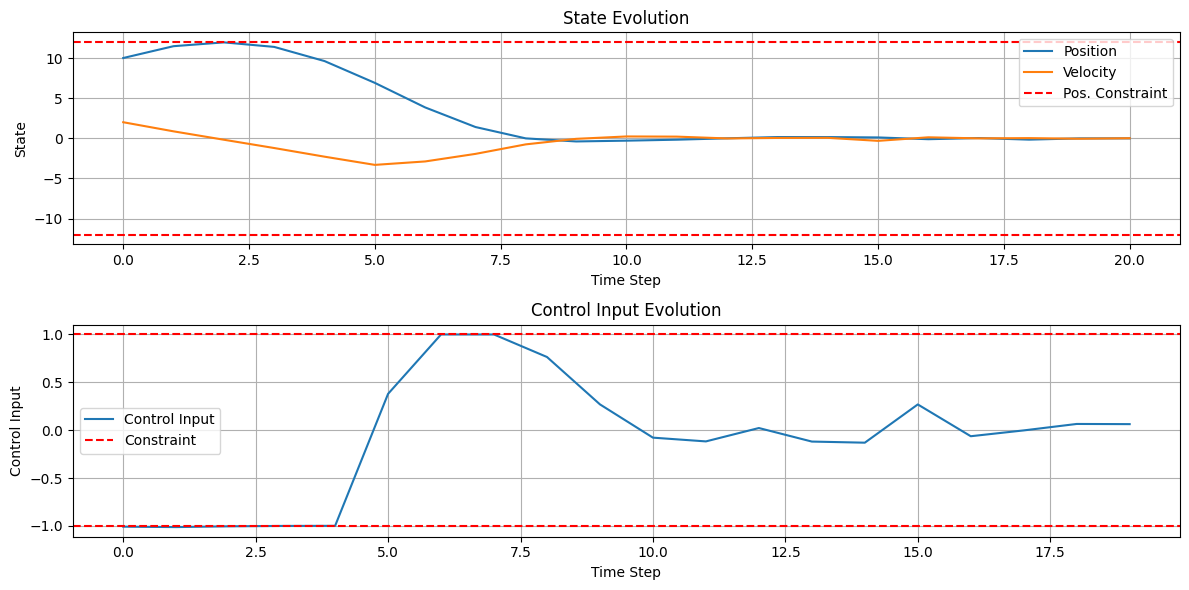

In [52]:
# Plot the state x
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x_hist[0, :], label="Position")
plt.plot(x_hist[1, :], label="Velocity")
plt.axhline(y=x_max, color="r", linestyle="--", label="Pos. Constraint")
plt.axhline(y=x_min, color="r", linestyle="--")
plt.title("State Evolution")
plt.xlabel("Time Step")
plt.ylabel("State")
plt.legend()
plt.grid(True)

# Plot the control input u
plt.subplot(2, 1, 2)
plt.plot(u_hist[0, :], label="Control Input")
plt.title("Control Input Evolution")
plt.axhline(y=u_max, color="r", linestyle="--", label="Constraint")
plt.axhline(y=u_min, color="r", linestyle="--")
plt.xlabel("Time Step")
plt.ylabel("Control Input")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()